In [27]:
import numpy as np
import pandas as pd
import pymongo
from pymongo import MongoClient
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import pprint
import statsmodels.api as sm
import src.sentiment as snt

from datetime import datetime
import boto3
import os
import time
import subprocess

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from data.get_data import get_download_links

links_df = get_download_links()
links_df.head(20)

,month,link,downloaded,size_in_bytes,comment_count
0,2005-12,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
1,2006-01,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
2,2006-02,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
3,2006-03,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
4,2006-04,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
5,2006-05,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
6,2006-06,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
7,2006-07,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
8,2006-08,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
9,2006-09,https://files.pushshift.io/reddit/comments/RC_...,False,0,0


In [336]:
# links_df[slice(116,144)]
links_df.loc[144:]

,month,link,downloaded,size_in_bytes,comment_count
144,2017-12,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
145,2018-01,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
146,2018-02,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
147,2018-03,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
148,2018-04,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
149,2018-05,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
150,2018-06,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
151,2018-07,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
152,2018-08,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
153,2018-09,https://files.pushshift.io/reddit/comments/RC_...,False,0,0


In [28]:
for idx, row in links_df.loc[144:144].iterrows():
    month = row['month']

    print('{}:\t{}'.format(idx,month), end='   ')
    start = time.time()
    snt.calculate_polarity(month)
    print('Done in {:1.1f} seconds'.format(time.time() - start))

144:	2017-12   Done in 522.3 seconds


In [25]:
client = MongoClient()
db = client['myreddit']

for idx, row in links_df.loc[144:150].iterrows():
    month = row['month']

    
    cll = db['comments-' + month]
    c1 = cll.find({'$and': 
                        [{'$expr': {'$ne': ['$body', '[deleted]']}},
                         {'$expr': {'$gt': ['$score', 0]}},
                         {'vader_sentiment': {'$exists': True}}]
                     })
    c2 = cll.find({'$and': 
                        [{'$expr': {'$ne': ['$body', '[deleted]']}},
                         {'$expr': {'$gt': ['$score', 0]}}]
                     })
    c3 = cll.find({'$and': 
                        [{'$expr': {'$ne': ['$body', '[deleted]']}},
                         {'$expr': {'$gt': ['$score', 0]}},
                         {'vader_sentiment': {'$exists': False}}]
                     })
    cc1 = c1.count()
    cc2 = c2.count()
    cc3 = c3.count()
    if (cc3 > 0) or (cc2 - cc3 - cc1 != 0):
        print('{}:\t{}'.format(idx,month))
        print(cc2)
        print(cc1)
        print(cc3)
        print(cc2 - cc3 - cc1)
        print()

#     calculate_polarity(month, analyzer='vader')

client.close()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.


144:	2017-12
896962
0
896962
0

145:	2018-01
959143
0
959143
0

146:	2018-02
848816
0
848816
0

147:	2018-03
915264
0
915264
0

148:	2018-04
817601
0
817601
0

149:	2018-05
859428
0
859428
0

150:	2018-06
994862
0
994862
0



In [3]:
def make_trend_line(series):
    X = sm.add_constant((np.arange(len(series)) + 1).reshape(-1, 1), prepend=False)
    linear_trend_ols = sm.OLS(series, X).fit()
    params = linear_trend_ols.params
    return linear_trend_ols.predict(X), params

In [4]:
def plot_stats(data_dict, title, axes, trendline=True):
    fig.suptitle(title, fontsize=16)
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    years_fmt = mdates.DateFormatter('%Y')

    dates = [datetime.strptime(k, '%Y-%m').date() for k, _ in sorted(data_dict.items())]
    awp = [v['avg_wght_pol'] for _, v in sorted(data_dict.items())]
    aawp = [v['avg_abs_wght_pol'] for _, v in sorted(data_dict.items())]
    aap = [v['avg_abs_pol'] for _, v in sorted(data_dict.items())]
    ccnt = [v['comment_count'] for _, v in sorted(data_dict.items())]
    awc = [v['avg_wordcount'] for _, v in sorted(data_dict.items())]

    axes[0].plot(dates, aawp)
    if trendline:
        aawp_trendline, params = make_trend_line(aawp)
        axes[0].plot(dates, aawp_trendline)
    axes[0].set_ylim([0, 1])
    axes[0].set_title('Absolute Weighted Polarity, /r/worldnews')

#     axes[1].plot(dates, aap)
#     axes[1].set_title('Absolute Comment Polarity')

    axes[1].plot(dates, ccnt)
    axes[1].set_title('Comment Count (monthly)')

    axes[1].set_yscale('log')
    axes[1].yaxis.set_major_formatter(ScalarFormatter())

    if trendline:
        return params

In [307]:
# from scipy.interpolate import make_interp_spline, BSpline

# # 300 represents number of points to make between T.min and T.max
# xnew = np.linspace(T.min(), T.max(), 300)

# spl = make_interp_spline(T, power, k=3)  # type: BSpline
# power_smooth = spl(xnew)

# plt.plot(xnew, power_smooth)
# plt.show()

In [9]:
comment_thresh = 5000

politics_data_pos_vader = snt.get_sentiment(20, 143, links_df, subreddit='politics', analyzer='vader')
politics_data_pos_vader = {k: v for k, v in politics_data_pos_vader.items() if v['comment_count'] > comment_thresh}

20 2007-08
30 2008-06
40 2009-04
50 2010-02
60 2010-12
70 2011-10
80 2012-08
90 2013-06
100 2014-04
110 2015-02
120 2015-12
130 2016-10
140 2017-08


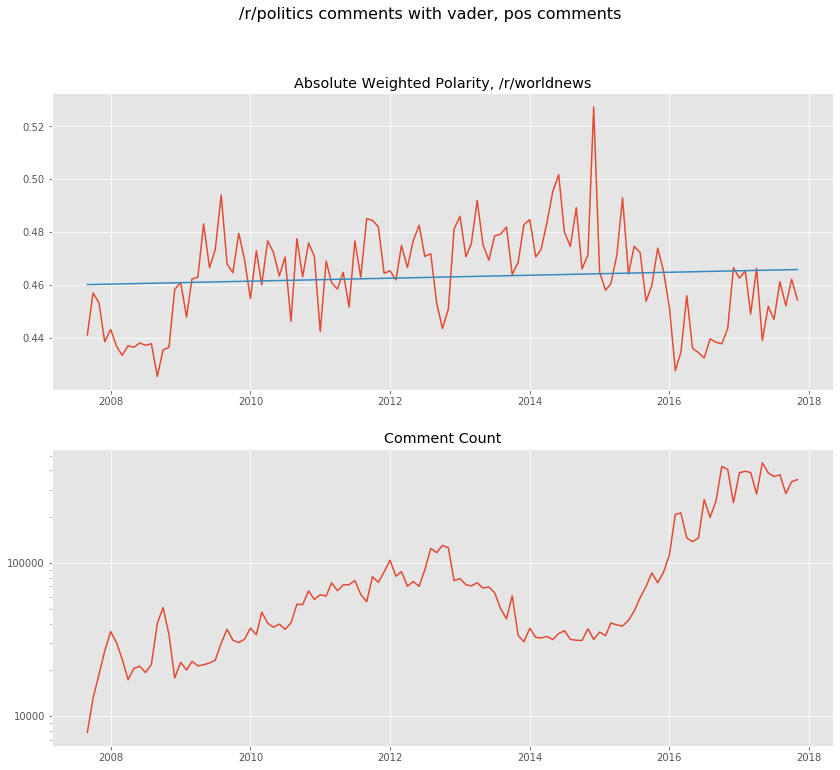

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(14, 12))
params = plot_stats(politics_data_pos_vader, '/r/politics comments with vader, pos comments', axes)

In [25]:
params[0]*12

0.000560624226262443

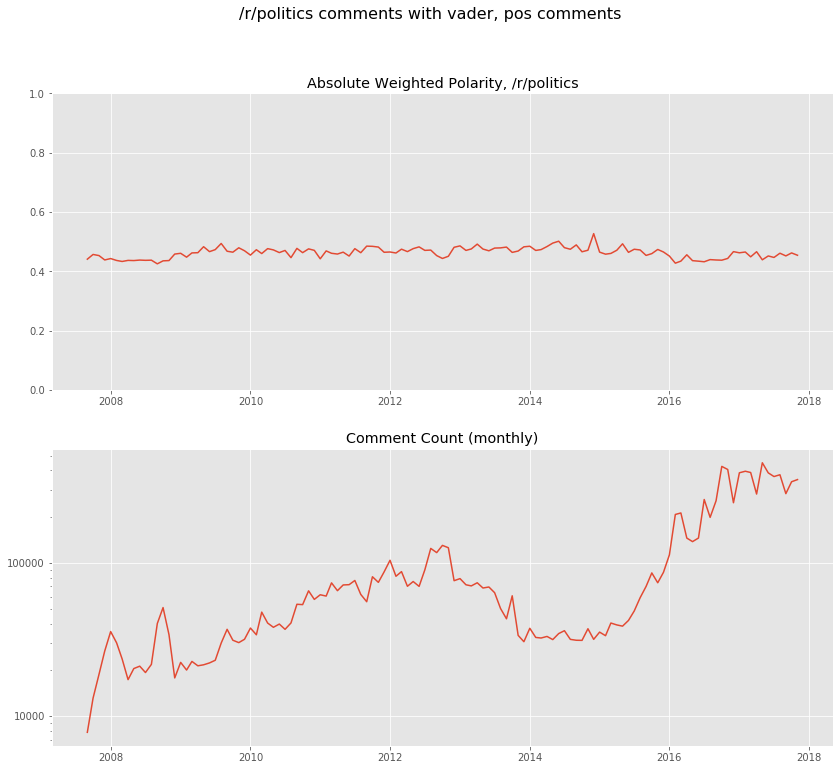

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(14, 12))
params = plot_stats(politics_data_pos_vader, '/r/politics comments with vader, pos comments', axes, trendline=False)

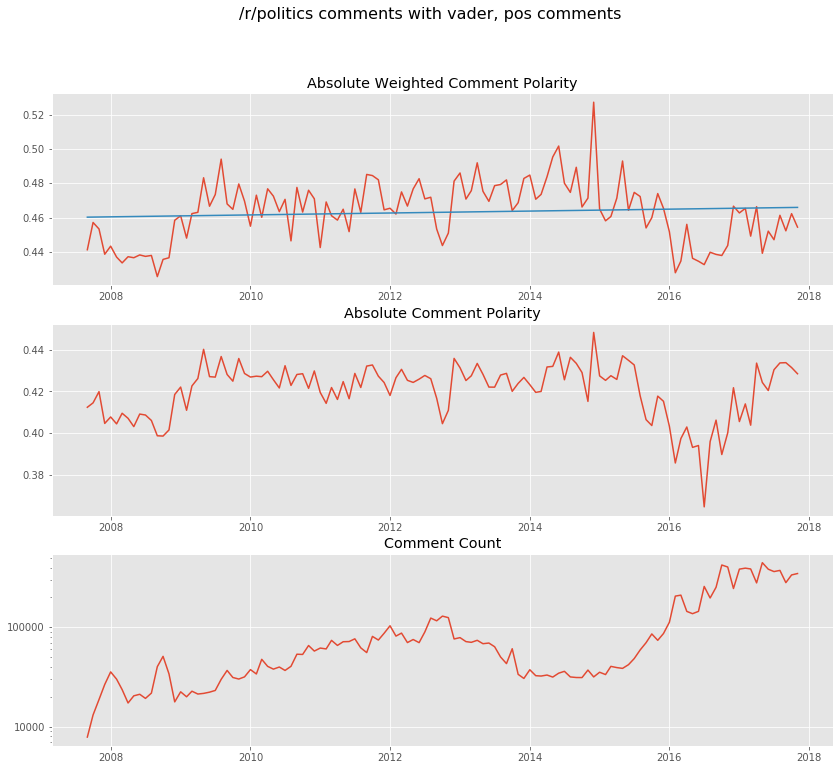

In [303]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))
params = plot_stats(politics_data_pos_vader, '/r/politics comments with vader, pos comments', axes)

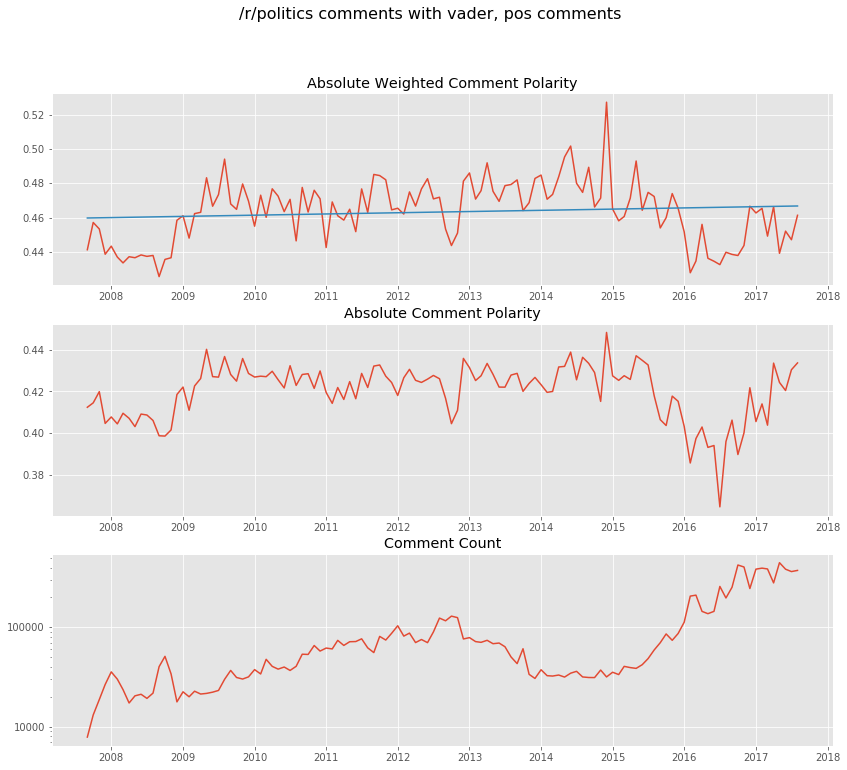

In [298]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))
params = plot_stats(politics_data_pos_vader, '/r/politics comments with vader, pos comments', axes)

In [17]:
comment_thresh = 5000

worldnews_data = snt.get_sentiment(20, 143, links_df, subreddit='worldnews')
worldnews_data = {k: v for k, v in worldnews_data.items() if v['comment_count'] > comment_thresh}

20 2007-08
30 2008-06
40 2009-04
50 2010-02
60 2010-12
70 2011-10
80 2012-08
90 2013-06
100 2014-04
110 2015-02
120 2015-12
130 2016-10
140 2017-08


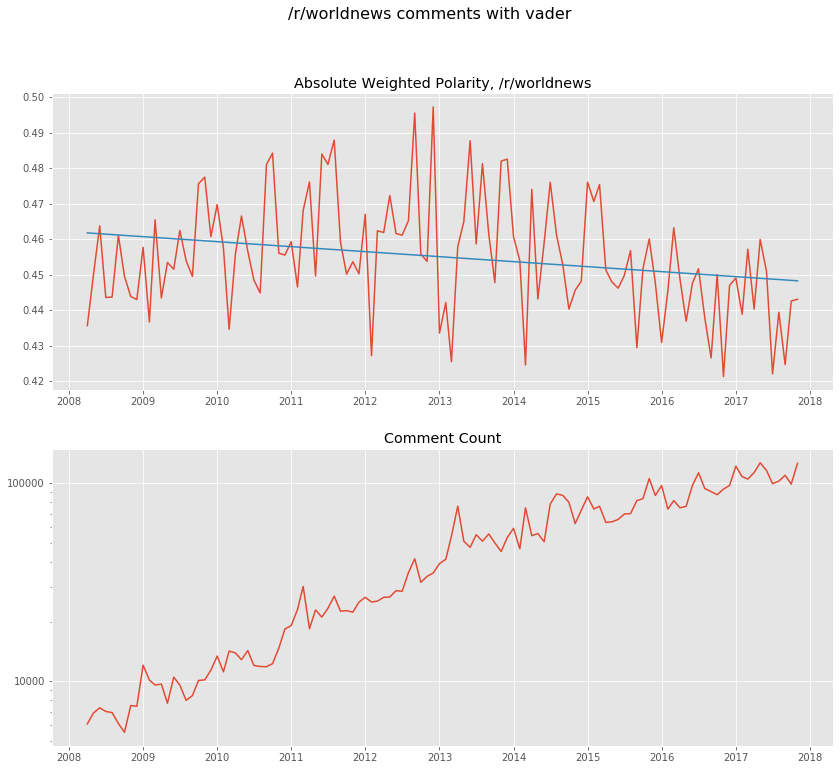

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(14, 12))
params = plot_stats(worldnews_data, '/r/worldnews comments with vader', axes)

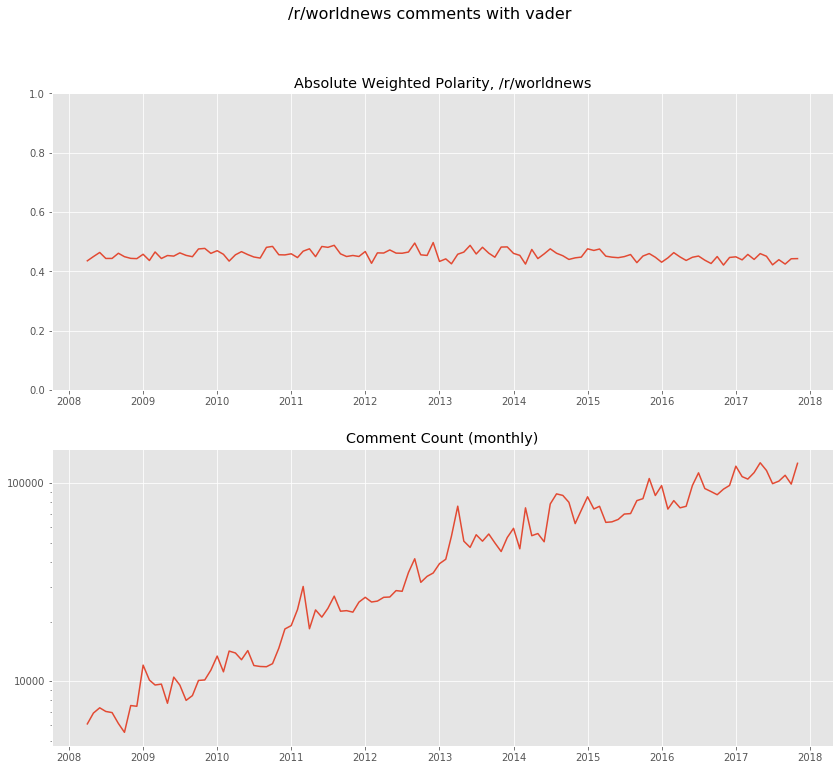

In [40]:
fig, axes = plt.subplots(2, 1, figsize=(14, 12))
params = plot_stats(worldnews_data, '/r/worldnews comments with vader', axes, trendline=False)

In [237]:
top_50_vader = {}
yearmonths = sorted(posts_all.distinct('yearmonth'))
for idx in range(len(yearmonths) - 1):
    # Get top 100 posts
    results = monthly_stats_top_posts(yearmonths[idx:idx+2], 'politics', post_limit=50)
    top_50_vader[yearmonths[idx]] = results
    if idx % 20 == 0:
        print(yearmonths[idx])

2007-08
2009-04
2010-12
2012-08
2014-04
2015-12
2017-08


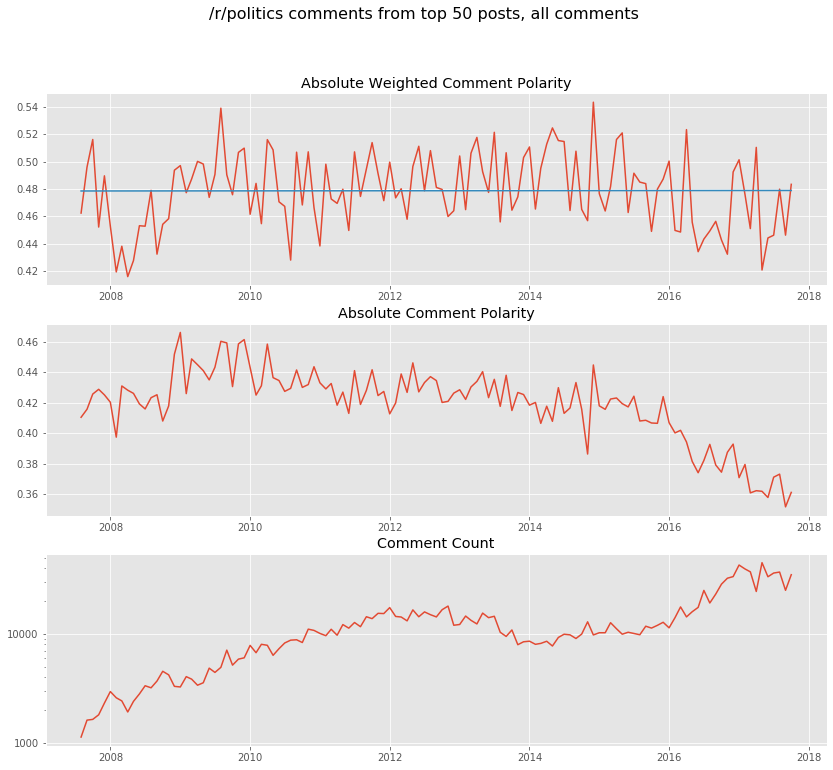

In [262]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))
params = plot_stats(top_50_vader, '/r/politics comments from top 50 posts, all comments', axes)

In [263]:
top_50_vader_pos = {}
yearmonths = sorted(posts_all.distinct('yearmonth'))
for idx in range(len(yearmonths) - 1):
    # Get top 100 posts
    results = monthly_stats_top_posts(yearmonths[idx:idx+2], 'politics', post_limit=50)
    top_50_vader_pos[yearmonths[idx]] = results
    if idx % 20 == 0:
        print(yearmonths[idx])

2007-08
2009-04
2010-12
2012-08
2014-04
2015-12
2017-08


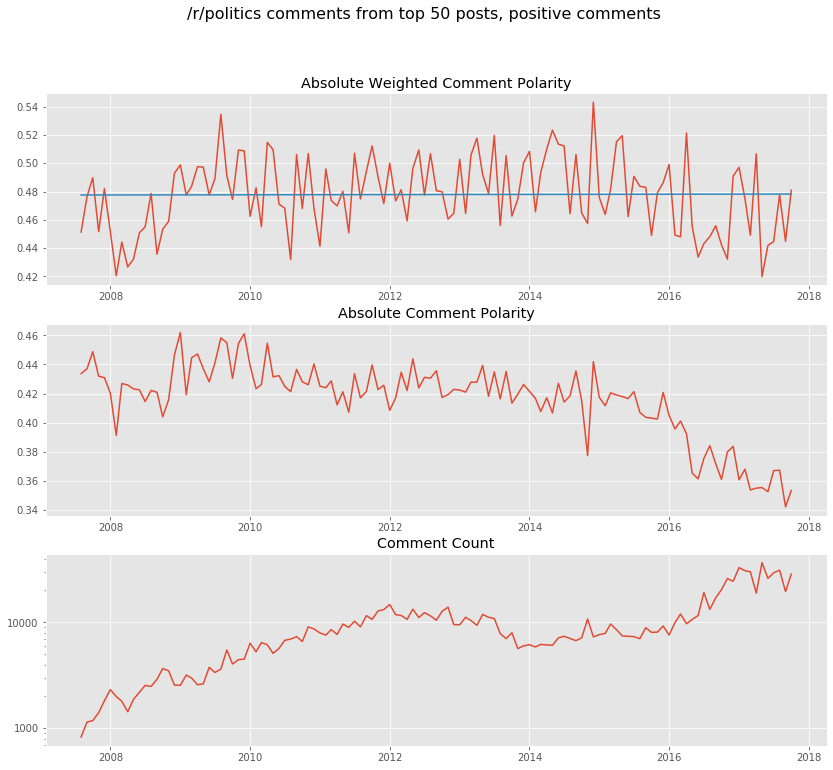

In [265]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))
params = plot_stats(top_50_vader_pos, '/r/politics comments from top 50 posts, positive comments', axes)

In [230]:
comment_thresh = 5000

politics_data_textblob = get_sentiment(20, 143, links_df, subreddit='politics', analyzer='textblob')
politics_data_textblob = {k: v for k, v in politics_data_textblob.items() if v['comment_count'] > comment_thresh}

20 2007-08
30 2008-06
40 2009-04
50 2010-02
60 2010-12
70 2011-10
80 2012-08
90 2013-06
100 2014-04
110 2015-02
120 2015-12
130 2016-10
140 2017-08


In [261]:
comment_thresh = 5000

politics_data_textblob_pos = get_sentiment(20, 143, links_df, subreddit='politics', analyzer='textblob')
politics_data_textblob_pos = {k: v for k, v in politics_data_textblob_pos.items() if v['comment_count'] > comment_thresh}

20 2007-08
30 2008-06
40 2009-04
50 2010-02
60 2010-12
70 2011-10
80 2012-08
90 2013-06
100 2014-04
110 2015-02
120 2015-12
130 2016-10
140 2017-08


In [28]:
def get_n_comments(db):
    """Gets number of comments across all months"""

    n_comments = 0
    for name in sorted([x for x in db.collection_names() if x.startswith('comments')]):
        coll = db[name]
        n_comments += coll.count()

    return n_comments

In [29]:
comment_thresh = 5000

all_comments = snt.get_sentiment(20, 143, links_df, analyzer='vader')
all_comments = {k: v for k, v in all_comments.items() if v['comment_count'] > comment_thresh}

20 2007-08
30 2008-06
40 2009-04
50 2010-02
60 2010-12
70 2011-10
80 2012-08
90 2013-06
100 2014-04
110 2015-02
120 2015-12
130 2016-10
140 2017-08


In [9]:
comment_thresh = 5000

all_politics_data_pos_vader = snt.get_sentiment(20, 143, links_df, subreddit='politics', analyzer='vader')
all_politics_data_pos_vader = {k: v for k, v in all_politics_data_pos_vader.items() if v['comment_count'] > comment_thresh}

20 2007-08
30 2008-06
40 2009-04
50 2010-02
60 2010-12
70 2011-10
80 2012-08
90 2013-06
100 2014-04
110 2015-02
120 2015-12
130 2016-10
140 2017-08


In [10]:
all_politics_data_pos_vader

{'2007-09': {'avg_wght_pol': -0.05153338957844765,
  'avg_abs_wght_pol': 0.4411687954012462,
  'avg_abs_pol': 0.4124021975213979,
  'comment_count': 7827,
  'avg_wordcount': 36.47170052382778},
 '2007-10': {'avg_wght_pol': -0.01866669507269101,
  'avg_abs_wght_pol': 0.4570920593799504,
  'avg_abs_pol': 0.4145214487659552,
  'comment_count': 13087,
  'avg_wordcount': 35.223733475968515},
 '2007-11': {'avg_wght_pol': 0.0072722192172271095,
  'avg_abs_wght_pol': 0.45330494259324877,
  'avg_abs_pol': 0.4198980155121811,
  'comment_count': 18695,
  'avg_wordcount': 37.03942230542926},
 '2007-12': {'avg_wght_pol': 0.007994856871180228,
  'avg_abs_wght_pol': 0.43853837063960954,
  'avg_abs_pol': 0.40465401831129333,
  'comment_count': 26541,
  'avg_wordcount': 33.3448249877548},
 '2008-01': {'avg_wght_pol': 0.007232124582349933,
  'avg_abs_wght_pol': 0.4432584499637823,
  'avg_abs_pol': 0.4077568736110668,
  'comment_count': 35549,
  'avg_wordcount': 32.57095839545416},
 '2008-02': {'avg_wght

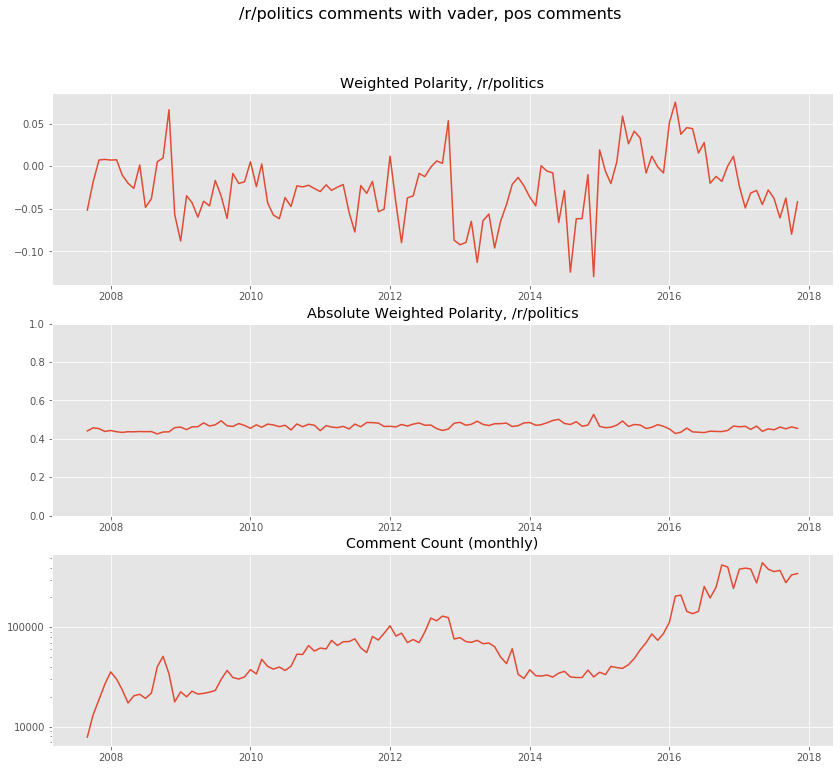

In [11]:
data_dict = all_politics_data_pos_vader


fig, axes = plt.subplots(3, 1, figsize=(14, 12))

fig.suptitle('/r/politics comments with vader, pos comments', fontsize=16)
years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')

dates = [datetime.strptime(k, '%Y-%m').date() for k, _ in sorted(data_dict.items())]
awp = [v['avg_wght_pol'] for _, v in sorted(data_dict.items())]
aawp = [v['avg_abs_wght_pol'] for _, v in sorted(data_dict.items())]
aap = [v['avg_abs_pol'] for _, v in sorted(data_dict.items())]
ccnt = [v['comment_count'] for _, v in sorted(data_dict.items())]
awc = [v['avg_wordcount'] for _, v in sorted(data_dict.items())]

axes[0].plot(dates, awp)
# axes[0].set_ylim([0, 1])
axes[0].set_title('Weighted Polarity, /r/politics')

axes[1].plot(dates, aawp)
# aawp_trendline, params = make_trend_line(aawp)
# axes[0].plot(dates, aawp_trendline)
axes[1].set_ylim([0, 1])
axes[1].set_title('Absolute Weighted Polarity, /r/politics')

#     axes[1].plot(dates, aap)
#     axes[1].set_title('Absolute Comment Polarity')

axes[2].plot(dates, ccnt)
axes[2].set_title('Comment Count (monthly)')

axes[2].set_yscale('log')
axes[2].yaxis.set_major_formatter(ScalarFormatter())

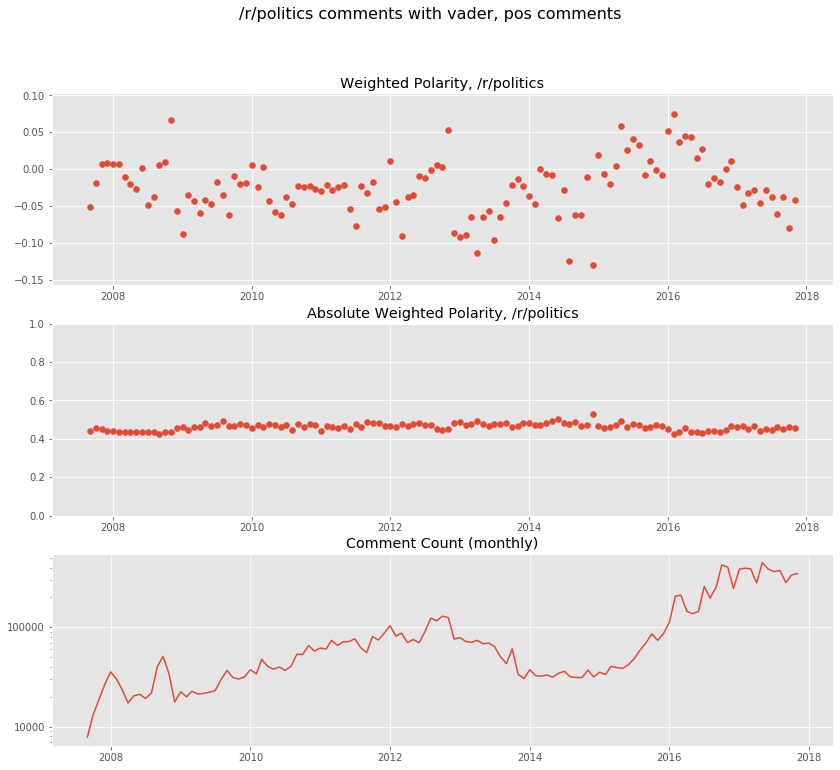

In [12]:
data_dict = all_politics_data_pos_vader


fig, axes = plt.subplots(3, 1, figsize=(14, 12))

fig.suptitle('/r/politics comments with vader, pos comments', fontsize=16)
years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')

dates = [datetime.strptime(k, '%Y-%m').date() for k, _ in sorted(data_dict.items())]
awp = [v['avg_wght_pol'] for _, v in sorted(data_dict.items())]
aawp = [v['avg_abs_wght_pol'] for _, v in sorted(data_dict.items())]
aap = [v['avg_abs_pol'] for _, v in sorted(data_dict.items())]
ccnt = [v['comment_count'] for _, v in sorted(data_dict.items())]
awc = [v['avg_wordcount'] for _, v in sorted(data_dict.items())]

axes[0].scatter(dates, awp)
# axes[0].set_ylim([0, 1])
axes[0].set_title('Weighted Polarity, /r/politics')

axes[1].scatter(dates, aawp)
# aawp_trendline, params = make_trend_line(aawp)
# axes[0].plot(dates, aawp_trendline)
axes[1].set_ylim([0, 1])
axes[1].set_title('Absolute Weighted Polarity, /r/politics')

#     axes[1].plot(dates, aap)
#     axes[1].set_title('Absolute Comment Polarity')

axes[2].plot(dates, ccnt)
axes[2].set_title('Comment Count (monthly)')

axes[2].set_yscale('log')
axes[2].yaxis.set_major_formatter(ScalarFormatter())